Preserving original sample rate of 44100 Hz...
Computing chromagram...


Chromagram: 100%|███████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 233.38it/s]


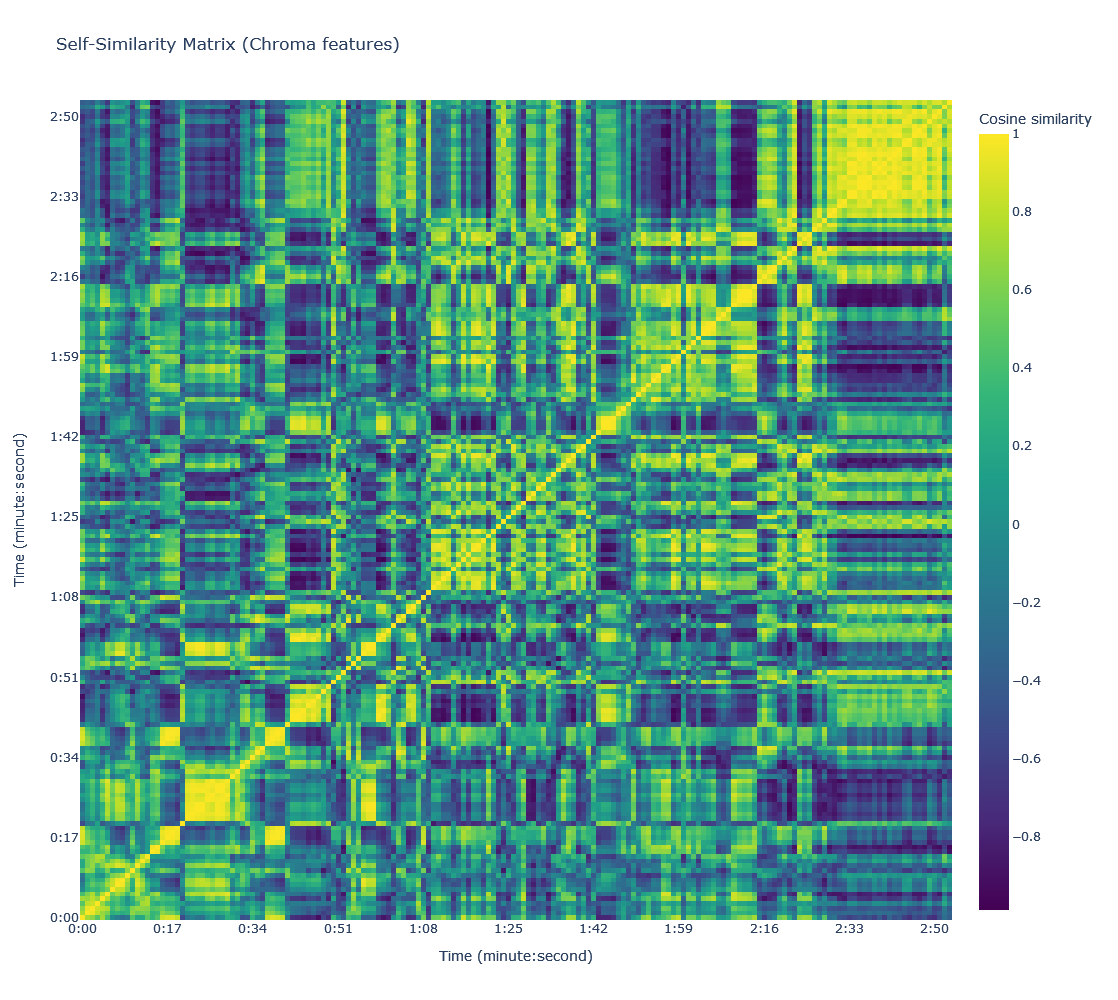

In [7]:
import librosa
import plotly.graph_objects as go
import numpy as np
from scipy.signal import convolve2d
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Customizable variables for easy configuration
resample = False  # Set to True to downsample, False to preserve original sample rate
custom_sr = 44100  # Desired sample rate for downsampling
analysis_method = 'chroma'  # Choose 'chroma', 'mfcc', or 'chroma+mfcc' for analysis
file_path = r'C:\Users\egorp\Nextcloud\code\playground\de natura sonorum - première série - dynamique de la résonance.wav'  # Path to the audio file
mfcc_start = 0  # Start of MFCC coefficient range (inclusive)
mfcc_end = 19  # End of MFCC coefficient range (exclusive)
window = 1  # Window size in seconds for feature extraction
diagonal_smooth_width = 1  # Width for diagonal smoothing in the similarity matrix

def diagonal_smooth(mat, width):
    """
    Apply diagonal smoothing to a matrix.

    Args:
        mat (np.ndarray): The input matrix to smooth.
        width (int): The width of the smoothing kernel. Must be a positive integer.

    Returns:
        np.ndarray: The diagonally smoothed matrix.
    """
    if width <= 1:
        return mat
    kernel = np.eye(width) / width
    smoothed = convolve2d(mat, kernel, mode='same', boundary='symm')
    return smoothed

def load_and_resample_audio(file_path, resample, custom_sr):
    """
    Load and optionally resample an audio file.

    Args:
        file_path (str): Path to the audio file.
        resample (bool): Whether to resample the audio.
        custom_sr (int): The target sample rate for resampling.

    Returns:
        tuple: A tuple containing the audio time series (y) and its sample rate (sr).
    """
    if resample:
        print(f"Downsampling to {custom_sr} Hz...")
        y, sr = librosa.load(file_path, mono=True, sr=custom_sr)
    else:
        y, sr = librosa.load(file_path, mono=True, sr=None)
        print(f"Preserving original sample rate of {sr} Hz...")
    return y, sr

def extract_features(y, sr, hop_length, analysis_method):
    """
    Extract specified audio features (chroma, MFCC, or both) from an audio signal.

    Args:
        y (np.ndarray): The audio time series.
        sr (int): The sample rate of the audio time series.
        hop_length (int): The number of samples between successive frames.
        analysis_method (str): The method of analysis ('chroma', 'mfcc', 'chroma+mfcc').

    Returns:
        np.ndarray: The extracted feature matrix.
    """
    features = None
    title = ""

    # Extract chroma features if required
    if analysis_method in ['chroma', 'chroma+mfcc']:
        chroma_features = _extract_chroma_features(y, sr, hop_length)
        features = chroma_features
        title = 'Self-Similarity Matrix (Chroma features)'

    # Extract MFCC features if required
    if analysis_method in ['mfcc', 'chroma+mfcc']:
        mfcc_features = _extract_mfcc_features(y, sr, hop_length)
        if features is None:
            features = mfcc_features
            title = 'Self-Similarity Matrix (MFCC features)'
        else:
            features = np.concatenate((features, mfcc_features), axis=0)
            title = 'Self-Similarity Matrix (Chroma + MFCC features)'

    if features is None:
        raise ValueError(f"Invalid analysis method: {analysis_method}. Choose 'chroma', 'mfcc', or 'chroma+mfcc'.")

    return features, title


def _extract_chroma_features(y, sr, hop_length):
    """
    Extract chroma features from an audio signal.

    Args:
        y (np.ndarray): The audio time series.
        sr (int): The sample rate of the audio time series.
        hop_length (int): The number of samples between successive frames.

    Returns:
        np.ndarray: The extracted chroma feature matrix.
    """
    print("Computing chromagram...")
    chroma_features = []
    for i in tqdm(range(0, len(y), hop_length), desc="Chromagram"):
        frame = y[i:i+hop_length]
        c = librosa.feature.chroma_stft(y=frame, sr=sr)
        chroma_features.append(np.mean(c, axis=1))
    return np.array(chroma_features).T

def _extract_mfcc_features(y, sr, hop_length):
    """
    Extract MFCC features from an audio signal.

    Args:
        y (np.ndarray): The audio time series.
        sr (int): The sample rate of the audio time series.
        hop_length (int): The number of samples between successive frames.

    Returns:
        np.ndarray: The extracted MFCC feature matrix.
    """
    print("Computing MFCCs...")
    mfcc_features = []
    for i in tqdm(range(0, len(y), hop_length), desc="MFCC"):
        frame = y[i:i+hop_length]
        m = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=mfcc_end)
        m = m[mfcc_start:mfcc_end, :]
        mfcc_features.append(np.mean(m, axis=1))
    return np.array(mfcc_features).T

def plot_similarity_matrix(ssm, title, time_labels):
    """
    Plot a self-similarity matrix with time labels using Plotly, setting the plot size to 1000x1000 pixels,
    and displaying a limited number of tick labels on both axes to avoid clutter.

    Args:
        ssm (np.ndarray): The self-similarity matrix to plot.
        title (str): The title for the plot.
        time_labels (list): Time labels for the x and y axes.
    """
    # Calculate the step size to select 10 tick values evenly across the labels
    step_size = len(time_labels) // 10
    tickvals = [i for i in range(0, len(time_labels), step_size)]

    heatmap = go.Heatmap(
        x=time_labels,
        y=time_labels,
        z=ssm,
        colorscale='viridis',
        colorbar=dict(title='Cosine similarity'),
    )

    layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Time (minute:second)',
            tickvals=tickvals,
            ticktext=[time_labels[i] for i in tickvals]
        ),
        yaxis=dict(
            title='Time (minute:second)',
            tickvals=tickvals,
            ticktext=[time_labels[i] for i in tickvals]
        ),
        autosize=False,
        width=1000,
        height=1000,
    )

    fig = go.Figure(data=[heatmap], layout=layout)
    fig.show()



# Main execution flow
y, sr = load_and_resample_audio(file_path, resample, custom_sr)
hop_length = int(sr * window)
features, title = extract_features(y, sr, hop_length, analysis_method)
scaler = StandardScaler()
features_norm = scaler.fit_transform(features.T)
ssm = cosine_similarity(features_norm)
ssm_smoothed = diagonal_smooth(ssm, diagonal_smooth_width)
duration_sec = librosa.get_duration(y=y, sr=sr)
time_data_sec = np.linspace(0, duration_sec, num=ssm_smoothed.shape[0])
time_data_min_sec = [f"{int(t // 60)}:{int(t % 60):02}" for t in time_data_sec]
plot_similarity_matrix(ssm_smoothed, title, time_data_min_sec)
